### Imports

In [1]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, \
                                       ZeroPadding2D

from keras.optimizers import SGD, Adam, Adadelta
from keras.utils import np_utils
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
#import cv2
import math
import pickle
import datetime
import pandas as pd
import glob

import os
import tensorflow as tf

Using TensorFlow backend.


### Read CSV into Notebook

In [2]:
with tf.Session() as sess:
  devices = sess.list_devices()
  print(devices)

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 17188723846501126583), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11280557671, 4447604996927362443)]


In [3]:
csv_path = os.getcwd() + '/Distracted_Data/driver_imgs_list.csv'
d_csv = pd.read_csv(csv_path)

### Class Definitions

The 10 classes to predict are:  

c0: safe driving  
c1: texting - right  
c2: talking on the phone - right  
c3: texting - left  
c4: talking on the phone - left  
c5: operating the radio  
c6: drinking  
c7: reaching behind  
c8: hair and makeup  
c9: talking to passenger  

In [4]:
class_dict = {
    'c0': "safe driving",
    'c1': "texting - right",
    'c2': "talking on the phone - right",
    'c3': "texting - left",
    'c4': "talking on the phone - left ",
    'c5': "operating the radio ",
    'c6': "drinking",
    'c7': "reaching behind",
    'c8': "hair and makeup ",
    'c9': "talking to passenger ",
} 

### Read in Images

(480, 640, 3)


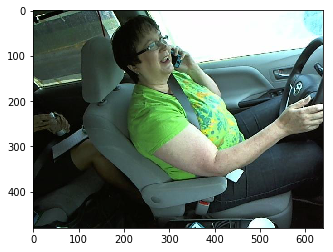

In [5]:
list_of_test_image_urls = glob.glob(os.getcwd() + '/Distracted_Data/imgs/test/*.*')

first_test_image = plt.imread(list_of_test_image_urls[100])

print(first_test_image.shape)
#list_of_test_image_urls[0]
plt.imshow(first_test_image)
plt.show()

### Build a Simple Keras Model

In [4]:
train_path = os.getcwd() + '/Distracted_Data/imgs/train/'

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

img_height = 100
img_width = 100
img_channels = first_test_image.shape[2]



#base_model = VGG19(weights='imagenet', include_top=False,input_shape=(img_height,img_width,img_channels))
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(img_height,img_width,img_channels))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 49, 49, 32)   96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 49, 49, 32)   0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [8]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

(0, 'input_1', False)
(1, 'conv2d_1', False)
(2, 'batch_normalization_1', False)
(3, 'activation_1', False)
(4, 'conv2d_2', False)
(5, 'batch_normalization_2', False)
(6, 'activation_2', False)
(7, 'conv2d_3', False)
(8, 'batch_normalization_3', False)
(9, 'activation_3', False)
(10, 'max_pooling2d_1', False)
(11, 'conv2d_4', False)
(12, 'batch_normalization_4', False)
(13, 'activation_4', False)
(14, 'conv2d_5', False)
(15, 'batch_normalization_5', False)
(16, 'activation_5', False)
(17, 'max_pooling2d_2', False)
(18, 'conv2d_9', False)
(19, 'batch_normalization_9', False)
(20, 'activation_9', False)
(21, 'conv2d_7', False)
(22, 'conv2d_10', False)
(23, 'batch_normalization_7', False)
(24, 'batch_normalization_10', False)
(25, 'activation_7', False)
(26, 'activation_10', False)
(27, 'average_pooling2d_1', False)
(28, 'conv2d_6', False)
(29, 'conv2d_8', False)
(30, 'conv2d_11', False)
(31, 'conv2d_12', False)
(32, 'batch_normalization_6', False)
(33, 'batch_normalization_8', False)
(34

In [13]:
batch_size=32
nb_epochs=5

In [14]:
import keras
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001), metrics=['accuracy'])

chkptk = keras.callbacks.ModelCheckpoint('Inception_best_Frozen.h5',save_best_only = 'True')


train_datagen = ImageDataGenerator(rescale=1./255,
    zoom_range=0.4,
    rotation_range=0.2, 
    height_shift_range= 0.4, 
    width_shift_range=0.4, 
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation') # set as validation data

history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    #samples_per_epoch = 15000,
    validation_data = validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs = nb_epochs, verbose = 1,callbacks = [chkptk,keras.callbacks.EarlyStopping(monitor = 'val_loss',verbose = 1, patience = 5)])

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Epoch 1/5
560/560 [==============================] - 154s 275ms/step - loss: 2.3200 - acc: 0.1271 - val_loss: 2.6249 - val_acc: 0.1223
Epoch 2/5
560/560 [==============================] - 148s 265ms/step - loss: 2.2787 - acc: 0.1546 - val_loss: 2.6783 - val_acc: 0.1346
Epoch 3/5
560/560 [==============================] - 148s 264ms/step - loss: 2.2604 - acc: 0.1640 - val_loss: 2.7825 - val_acc: 0.1495
Epoch 4/5
560/560 [==============================] - 148s 265ms/step - loss: 2.2468 - acc: 0.1725 - val_loss: 2.7876 - val_acc: 0.1398
Epoch 5/5
560/560 [==============================] - 148s 264ms/step - loss: 2.2386 - acc: 0.1783 - val_loss: 2.7014 - val_acc: 0.1441


In [16]:
nb_epochs=50
for layer in model.layers[:175]:
   layer.trainable = False
for layer in model.layers[175:]:
   layer.trainable = True

In [18]:

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

chkptk = keras.callbacks.ModelCheckpoint('Inception_best_UnFrozen.h5',save_best_only = 'True')

history2=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs = nb_epochs, verbose = 1,callbacks = [chkptk,keras.callbacks.EarlyStopping(monitor = 'val_loss',verbose = 1, patience = 10)])
# Save the model

Epoch 1/50
560/560 [==============================] - 162s 289ms/step - loss: 2.0861 - acc: 0.2433 - val_loss: 2.3159 - val_acc: 0.2131
Epoch 2/50
560/560 [==============================] - 152s 271ms/step - loss: 1.7528 - acc: 0.3783 - val_loss: 2.2956 - val_acc: 0.2830
Epoch 3/50
560/560 [==============================] - 151s 270ms/step - loss: 1.4728 - acc: 0.4814 - val_loss: 2.3050 - val_acc: 0.3324
Epoch 4/50
560/560 [==============================] - 152s 272ms/step - loss: 1.2812 - acc: 0.5504 - val_loss: 2.2006 - val_acc: 0.3731
Epoch 5/50
560/560 [==============================] - 151s 270ms/step - loss: 1.1510 - acc: 0.5968 - val_loss: 2.1395 - val_acc: 0.4001
Epoch 6/50
560/560 [==============================] - 152s 271ms/step - loss: 1.0472 - acc: 0.6345 - val_loss: 2.2936 - val_acc: 0.3749
Epoch 7/50
560/560 [==============================] - 151s 269ms/step - loss: 0.9831 - acc: 0.6593 - val_loss: 2.2147 - val_acc: 0.4023
Epoch 8/50
560/560 [============================

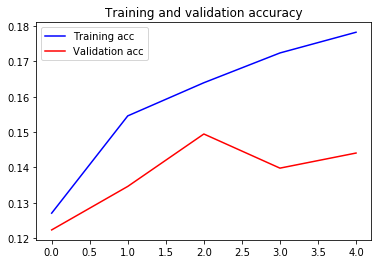

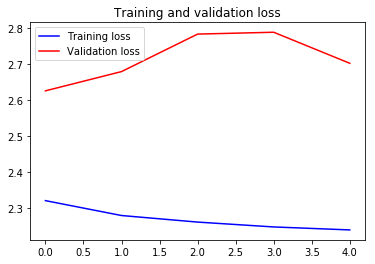

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [5]:
import numpy as np
from sklearn.metrics import log_loss
import keras
batch_size=32

train_datagen = ImageDataGenerator(rescale=1./255,
    validation_split=0.2) # set validation split
validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(100, 100),
    batch_size=batch_size,
    shuffle=False,
    subset='validation') # set as validation data

# Evaluate your model.
scores = model.evaluate_generator(validation_generator, steps=validation_generator.samples // batch_size)
print("Loss: " + str(scores[0]) + " Accuracy: " + str(scores[1]))

predictions = model.predict_generator(validation_generator, steps=(validation_generator.samples // batch_size)+1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())  

score = log_loss(validation_generator.classes, predictions)
print ("log loss score",score)


Found 4481 images belonging to 10 classes.
Loss: 0.9887706226536206 Accuracy: 0.6910714285714286
('log loss score', 1.4198140537039976)


Create sample submission

In [ ]:
import submission_function
#Create submission file
submission_function.create_submission_file(100,100,model,"Inception_submission")

#### Log loss score for Inception model from the project submission on Kaggle is 2.23533